# Metaprogramming

## The ParticleGroup example

In [1]:
import Sobol
using Plots, LinearAlgebra

    ParticleGroup{D,V}(n_particles, charge, mass)

- `D` : number of dimension in physical space
- `V` : number of dimension in phase space
- `n` : number of particles

In [2]:
mutable struct ParticleGroup{D,V}

    n_particles       :: Int64
    data              :: Array{Float64, 2}

    function ParticleGroup{D,V}(n) where {D, V}

        data = zeros( Float64, (D+V, n))
        new( n, data)
    end
end

Set position of ith particle of p to x

In [3]:
@generated function set_x!( p :: ParticleGroup{D,V}, i, x :: Float64 ) where {D, V}

    :(p.data[1, i] = x)

end

set_x! (generic function with 1 method)

Set position of ith particle of p to x when x is a vector

In [4]:
@generated function set_x!( p :: ParticleGroup{D,V}, i, x :: Vector{Float64} ) where {D, V}

     :(for j in 1:$D p.data[j, i] = x[j] end)

end

set_x! (generic function with 2 methods)

Set velocity of ith particle of p to v

In [5]:
@generated function set_v!( p :: ParticleGroup{D,V}, i, v :: Float64 ) where {D, V}

    :(p.data[$D+1, i] = v)

end

set_v! (generic function with 1 method)

Set velocity of ith particle of p to v

In [6]:
@generated function set_v!( p :: ParticleGroup{D,V}, i, v :: Vector{Float64} ) where {D, V}

    :(for j in 1:$V p.data[$D+j, i] = v[j] end)

end

set_v! (generic function with 2 methods)

Get position of ith particle of p

In [7]:
@generated function get_x( p :: ParticleGroup{D,V}, i ) where {D, V}

     :(p.data[1:$D, i])

end

get_x (generic function with 1 method)

Get velocity of ith particle of p

In [8]:
@generated function get_v( p :: ParticleGroup{D,V}, i ) where {D, V}

     :(p.data[$D+1:$D+$V, i])
end

get_v (generic function with 1 method)

Sampling from a probability distribution to initialize Landau damping

In [9]:
function landau_sampling!( pg :: ParticleGroup{1,2}, alpha, kx )

    function newton(r)
        x0, x1 = 0.0, 1.0
        r *= 2π / kx
        while (abs(x1-x0) > 1e-12)
            p = x0 + alpha * sin( kx * x0) / kx
            f = 1 + alpha * cos( kx * x0)
            x0, x1 = x1, x0 - (p - r) / f
        end
        x1
    end

    s = Sobol.SobolSeq(2)
    nbpart = pg.n_particles

    for i=1:nbpart

        v = sqrt(-2 * log( (i-0.5)/nbpart))
        r1, r2 = Sobol.next!(s)
        θ = r1 * 2π
        set_x!(pg,  i, newton(r2))
        set_v!(pg,  i, [v * cos(θ), v * sin(θ)])
    end

end

landau_sampling! (generic function with 1 method)

In [10]:
n_particles = 10000
pg = ParticleGroup{1,2}( n_particles)
alpha, kx = 0.1, 0.5
landau_sampling!(pg, alpha, kx)

In [11]:
xp = vcat([get_x(pg, i) for i in 1:pg.n_particles]...)
vp = vcat([get_v(pg, i) for i in 1:pg.n_particles]'...);

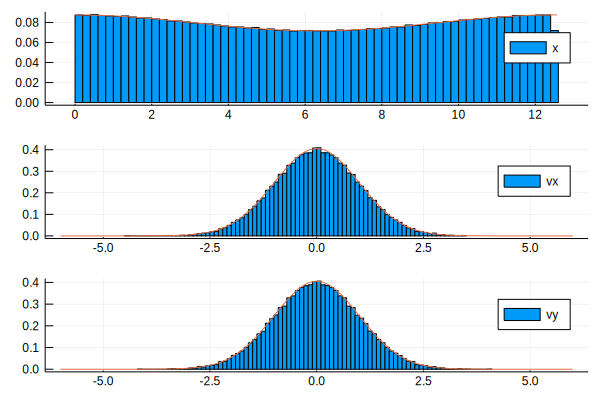

In [12]:
pp = plot(layout=(3,1))
histogram!(pp[1,1], xp, normalize=true, bins = 100, lab=:x)
plot!(pp[1,1], x -> (1+alpha*cos(kx*x))/(2π/kx), 0., 2π/kx, lab="")
histogram!(pp[2,1], vp[:,1], normalize=true, bins = 100, lab=:vx)
plot!(pp[2,1], v -> exp( - v^2 / 2) * 4 / π^2 , -6, 6, lab="")
histogram!(pp[3,1], vp[:,2], normalize=true, bins = 100, lab=:vy)
plot!(pp[3,1], v -> exp( - v^2 / 2) * 4 / π^2 , -6, 6, lab="")

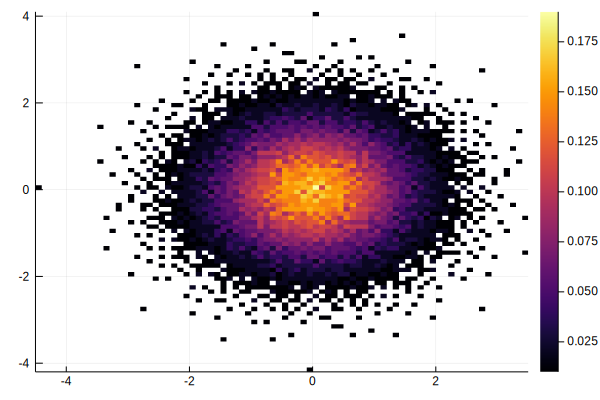

In [13]:
histogram2d(vp[:,1], vp[:,2], normalize=true, bins=100)

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*